In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely import geometry, ops
import matplotlib.pyplot as plt

%matplotlib inline

# Read in data from shapefiles

In [2]:
# Read in the datasets
streets0 = gpd.read_file('./sourcedata/streets/StatePlane/Street_Network_Database.shp')
sidewalks0 = gpd.read_file('./sourcedata/sidewalks/Sidewalks/Sidewalks.shp')

# Standardize datasets

In [3]:
# Strip metadata from new sidewalks/streets tables
streets = streets0.copy()[['COMPKEY', 'geometry']]

# Convert all sidewalks to LineStrings (also filters out invalid geometries)
sidewalk_cols = ['COMPKEY', 'SEGKEY', 'CURBRAMPHI', 'CURBRAMPLO', 'geometry']
sidewalks = sidewalks0[sidewalks0.geometry.type == 'LineString'].copy()[sidewalk_cols]

newrows = []
for i, row in sidewalks0[sidewalks0.geometry.type == 'MultiLineString'].iterrows():
    for geom in row.geometry:
        newrows.append(row.copy()[sidewalk_cols])
        newrows[-1].geometry = geom
sidewalks = pd.concat([sidewalks, gpd.GeoDataFrame(newrows)])

sidewalks.rename(columns={'CURBRAMPHI': 'curbramp_end', 'CURBRAMPLO': 'curbramp_start'}, inplace=True)

# This created duplicate indices, which currently have no meaning - reset the index
# and create a column for it
sidewalks.reset_index(drop=True, inplace=True)
sidewalks.reset_index(inplace=True)
sidewalks.rename(columns={'index': 'sidewalk_id'}, inplace=True)
streets.reset_index(inplace=True)
streets.rename(columns={'index': 'street_id'}, inplace=True)

# Dedupe sidewalk lines - for some reason this dataset has duplicated shapes
# .drop_duplicates didn't work directly on the geometry column, so need a
# temporary WKT text column
sidewalks['wkt'] = sidewalks.geometry.apply(lambda row: row.wkt)
sidewalks.drop_duplicates(['wkt'], inplace=True)
sidewalks.drop('wkt', 1, inplace=True)

# CRS is forgotten during some operations, re-copy
streets.crs = streets0.crs
sidewalks.crs = sidewalks0.crs

In [4]:
# Reproject to appropriate NAD83 in meters
streets.to_crs({'init': 'epsg:26910'}, inplace=True)
sidewalks.to_crs({'init': 'epsg:26910'}, inplace=True)

In [5]:
# Write to file at this point
streets.to_file('output/streets.shp')
sidewalks.to_file('output/sidewalks.shp')

In [6]:
# Create curbramps table based on sidewalks
curbend = sidewalks[sidewalks['curbramp_end'] == 'Y']
curbstart = sidewalks[sidewalks['curbramp_start'] == 'Y']

curbramps = gpd.GeoDataFrame(pd.concat([curbend.geometry.apply(lambda x: geometry.Point(x.coords[-1])), 
                                        curbstart.geometry.apply(lambda x: geometry.Point(x.coords[0]))]))

curbramps['SW_COMPKEY'] = pd.concat([curbend['COMPKEY'], curbstart['COMPKEY']])
curbramps['endtype'] = curbend.shape[0] * ['end'] + curbstart.shape[0] * ['start']

curbramps.head()

,geometry,SW_COMPKEY,endtype
0,POINT (553168.6489468224 5286337.994271296),330518,end
7,POINT (548122.4972355528 5279683.624783031),330261,end
10,POINT (551566.3801728879 5263993.261740751),330341,end
22,POINT (551571.5606561413 5264004.629260025),330342,end
24,POINT (547933.1957547202 5279683.855175902),330262,end


In [7]:
# Remove sidewalks that are almost exactly their streets - this happens when bad 'width'
# data was used to extrapolate sidewalks

print sidewalks.shape

sdw_st = pd.merge(sidewalks, streets, left_on='SEGKEY', right_on='COMPKEY')

def geoms_differ(geoseries, tol=0.1):
    sidewalk = geoseries['geometry_x']
    street = geoseries['geometry_y']
    
    sidewalk_points = [geometry.Point(coord) for coord in sidewalk.coords]
    
    distances = [point.distance(street) for point in sidewalk_points]
    
    if sum(distances) > tol:
        return True
    else:
        return False

sdw_st_clean = sdw_st[sdw_st.apply(geoms_differ, axis=1)]
sidewalks = sidewalks[sidewalks['COMPKEY'].isin(sdw_st_clean['COMPKEY_x'])]

print sidewalks.shape

(45569, 6)
(45533, 6)


# Trim sidewalk lines that intersect streets

In [8]:
# Trim sidewalk lines that intersects streets - keep the side that's on the centroid of the line
overlapping = gpd.sjoin(sidewalks[['sidewalk_id', 'geometry']], 
                        streets[['street_id', 'geometry']], 
                        how='inner', 
                        op='intersects', 
                        lsuffix='sw', 
                        rsuffix='st')

# The streets geometry column gets dropped, need to reselect it
overlapping['geometry_st'] = streets.loc[overlapping['street_id']]['geometry'].tolist()

print overlapping.shape
overlapping.head(10)

(6541, 5)


,sidewalk_id,geometry,index_st,street_id,geometry_st
0,0,LINESTRING (553093.1855578402 5286337.77174694...,33635,33635,LINESTRING (553174.0424251509 5286141.99908964...
8315,8315,LINESTRING (553167.6925544755 5286145.78556960...,33635,33635,LINESTRING (553174.0424251509 5286141.99908964...
10,10,LINESTRING (551370.3514823434 5264082.59666747...,27780,27780,LINESTRING (551514.4555440756 5264023.54738159...
3135,3135,LINESTRING (551373.4817165736 5263995.60772028...,27780,27780,LINESTRING (551514.4555440756 5264023.54738159...
22,22,LINESTRING (551375.5319602233 5264093.96418780...,27842,27842,LINESTRING (551563.4413877537 5264009.86178889...
22,22,LINESTRING (551375.5319602233 5264093.96418780...,31989,31989,LINESTRING (551600.0804006804 5264232.40211658...
33,33,LINESTRING (554257.7202917113 5282780.54905245...,20070,20070,LINESTRING (554182.331759876 5282778.620504319...
10985,10985,LINESTRING (554278.6501475611 5282787.30515523...,20070,20070,LINESTRING (554182.331759876 5282778.620504319...
34,34,"LINESTRING (551262.9286776893 5264170.2181216,...",10980,10980,LINESTRING (551166.4358181034 5264082.91422144...
37,37,LINESTRING (547075.7549287126 5282745.67299479...,28896,28896,LINESTRING (547069.5763487946 5282741.61158344...


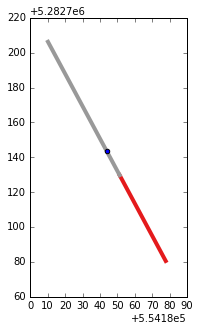

In [9]:
# Example - the central line would be kept, the others discarded
n = 33
split = overlapping.loc[n, 'geometry'].difference(overlapping.loc[n, 'geometry_st']).geoms
ax1 = gpd.GeoSeries(split).plot(linewidth=4)
# ax1.set_aspect(10)

split_mid = overlapping.loc[n, 'geometry'].interpolate(0.5, normalized=True)

plt.scatter(split_mid.x, split_mid.y, zorder=10)

fig = plt.gcf()
fig.set_size_inches(5, 5)

In [10]:
def trim_sidewalk(group, tol=1e-7, threshold=0.6, minlen=5, offset=0.5):
    '''Given intersecting sidewalk and street geometries, return the midpoint-containing
    sidewalk segment.'''
    changed = False
    
    index_sw = group['sidewalk_id'].iloc[0]
    sidewalk = group['geometry'].iloc[0]
    street = geometry.MultiLineString(list(group['geometry_st']))

    split = list(sidewalk.difference(street).geoms)
    
    # First, let's just try removing the two end pieces
    start = sidewalk.coords[0]
    end = sidewalk.coords[-1]
    changed = False

    n = len(split)
    if n == 1:
        # This shouldn't happen, but might as well catch it
        raise ValueError("Sidewalk and streets don't intersect")
    elif n == 2:
        # Only two geometries - can't remove both! Decide whether to keep one or both
        if split[0].length < minlen and split[1].length < minlen:
            # Keep the longer segment
            if split[0].length < split[1].length:
                changed = True
                split.pop(0)
            else:
                changed = True
                split.pop(1)

        else:
            if split[0].length < minlen:
                changed = True
                split.pop(0)
            elif split[1].length < minlen:
                changed = True
                split.pop()
    else:
        # There are more than 3 lines - removed end lines if they're below threshold
        
        # Separate ends from everything else
        keep = []
        for line in split:
            if start in line.coords:
                startline = line
            elif end in line.coords:
                endline = line
            else:
                keep.append(line)

        # Evaluate end lines same as before
        if startline.length > minlen:
            keep.append(startline)
        else:
            changed = True
        
        if endline.length > minlen:
            keep.append(endline)
        else:
            changed = True
        
    # Finally, many complex situations arise where trimming the
    # ends is not enough - instead, just keep the large remaining segment
    # above some threshold
    for line in split:
        if line.length > (0.5 * sidewalk.length):
            keep = [line]
            changed = True
    split = keep
    
    trimmed = ops.linemerge(split)

    # Any trimmed ends that currently touch the street - trim them back a little
    # Attempt to trim back by 'offset', unless sidewalk is currently shorter than that
    # TODO: Ideally, would only want to cut back the ends that were already trimmed.
    # Because we already split up and re-merged the sidewalk line, order is not
    # necessarily guaranteed, so we'd need to track that.
    if (trimmed.length / 2) < offset:
        # Trim by 10% on each end
        first = trimmed.interpolate(0.1, normalized=True)
        last = trimmed.interpolate(0.9, normalized=True)
    else:
        first = trimmed.interpolate(offset)
        last = trimmed.interpolate(trimmed.length - offset)
  
    trimmed_arr = list(trimmed.coords)
    trimmed_arr[0] = (first.x, first.y)
    trimmed_arr[-1] = (last.x, last.y)
    
    trimmed = geometry.LineString(trimmed_arr)
    
    return gpd.GeoDataFrame({'sidewalk_id': [index_sw], 
                             'geometry': [trimmed],
                             'changed': changed}) 


# fixed_sw = overlapping[overlapping['sidewalk_id'] == 13213].groupby('sidewalk_id').apply(trim_sidewalk).unstack()
fixed_sw = overlapping.groupby('sidewalk_id').apply(trim_sidewalk).unstack()
fixed_sw.columns = fixed_sw.columns.get_level_values(0)
fixed_sw.index.name = ''

# Update the geometry column for sidewalks that intersected
sidewalks.update(fixed_sw)
# For some reason the id column gets turned into a float
sidewalks['sidewalk_id'] = sidewalks['sidewalk_id'].astype(int)

# Separately save 'changed' dataset
changed = gpd.GeoDataFrame(fixed_sw[fixed_sw['changed']])


fixed_sw.head()

,changed,geometry,sidewalk_id
,,,
0,True,LINESTRING (553094.0125750737 5286337.77418563...,0
10,True,LINESTRING (551370.8064634119 5264082.38932180...,10
22,True,LINESTRING (551375.986941293 5264093.756842134...,22
33,True,LINESTRING (554231.0435601913 5282830.19993804...,33
34,True,LINESTRING (551263.3156520326 5264169.90149744...,34


In [11]:
ex = overlapping[overlapping['sidewalk_id'] == 13213]
split = ex['geometry'].iloc[0].difference(ex['geometry_st'].iloc[0])

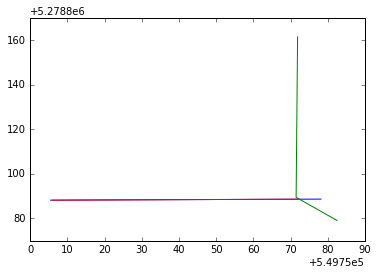

In [12]:
plt.plot(*ex['geometry'].iloc[0].xy)
plt.plot(*ex['geometry_st'].iloc[0].xy)
plt.plot(*fixed_sw[fixed_sw['sidewalk_id'] == 13213].geometry.iloc[0].xy)

In [13]:
# Report how many are still 'intersecting', i.e. would've been cut into too small of pieces
intersecting = gpd.sjoin(sidewalks[['sidewalk_id', 'geometry']], 
                         streets[['street_id', 'geometry']], 
                         how='inner', 
                         op='intersects', 
                         lsuffix='sw', 
                         rsuffix='st')

print 'Intersecting: ', intersecting.shape
print 'Changed: ', changed.shape
print 'Total: ', fixed_sw.shape

Intersecting:  (980, 4)
Changed:  (4739, 3)
Total:  (4903, 3)


In [14]:
intersecting.to_file('output/intersecting.shp')
changed['changed'] = changed['changed'].astype(int)
fixed_sw['changed'] = fixed_sw['changed'].astype(int)
changed.to_file('output/changed.shp')
gpd.GeoDataFrame(fixed_sw).to_file('output/total.shp')

# Fix easy dangles

In [15]:
# There are a lot of dangles - slight overshoots where sidewalks intersect
# To fix them, we need to identify them and them remove the overshoots

# TODO: address self-self intersection (i.e. within a single LineString geometry)

# Find sidewalks that intersect near their ends

sidewalk_ixn = gpd.sjoin(sidewalks[['sidewalk_id', 'geometry']], 
                         sidewalks[['sidewalk_id', 'geometry']], 
                         how='inner', 
                         op='intersects', 
                         lsuffix='s1', 
                         rsuffix='s2')

# Ignore self-self
sidewalk_ixn = sidewalk_ixn[sidewalk_ixn['sidewalk_id_s1'] != sidewalk_ixn['sidewalk_id_s2']]

# Restore geometry column for 'other' sidewalk
sidewalk_ixn['geometry_s2'] = sidewalks.loc[sidewalk_ixn['sidewalk_id_s2']]['geometry'].tolist()

# Add intersection point(s)
sidewalk_ixn['intersection'] = sidewalk_ixn.apply(lambda row: row['geometry'].intersection(row['geometry_s2']), axis=1)

# Remove rows that intersect for a line or more (TODO: flag for fixing manually)
sidewalk_ixn = sidewalk_ixn[sidewalk_ixn['intersection'].apply(lambda geom: geom.type) != 'GeometryCollection']
sidewalk_ixn = sidewalk_ixn[sidewalk_ixn['intersection'].apply(lambda geom: geom.type) != 'MultiLineString']

print sidewalk_ixn.shape

sidewalk_ixn.head()

(54070, 6)


,sidewalk_id_s1,geometry,index_s2,sidewalk_id_s2,geometry_s2,intersection
0,0,LINESTRING (553094.0125750737 5286337.77418563...,8315,8315,LINESTRING (553167.3477410791 5286158.67110858...,POINT (553162.5495850043 5286337.976285667)
9348,9348,LINESTRING (553173.1995025844 5286166.85702321...,8315,8315,LINESTRING (553167.3477410791 5286158.67110858...,POINT (553166.70622311 5286182.644378993)
8315,8315,LINESTRING (553167.3477410791 5286158.67110858...,0,0,LINESTRING (553094.0125750737 5286337.77418563...,POINT (553162.5495850043 5286337.976285667)
9348,9348,LINESTRING (553173.1995025844 5286166.85702321...,0,0,LINESTRING (553094.0125750737 5286337.77418563...,POINT (553102.8911546955 5286337.80036654)
0,0,LINESTRING (553094.0125750737 5286337.77418563...,9348,9348,LINESTRING (553173.1995025844 5286166.85702321...,POINT (553102.8911546955 5286337.80036654)


In [16]:
# A given sidewalk may intersect several other sidewalks, even the same one multiple times
# This strategy will therefore group by 'sidewalk 1' and tally up all the other intersecting

# First, for each sidewalk that intersects any other sidewalk, find all intersection points
def agg_ixn(group):
    if group.shape[0] == 1:
        ixn_type = group['intersection'].iloc[0].type
        if ixn_type == 'Point':
            return geometry.MultiPoint(list(group['intersection']))
        elif ixn_type == 'MultiPoint':
            return group['intersection'].iloc[0]
        else:
            raise Exception('Odd Geometry Encountered: '.format(ixn_type))
    else:
        geoms = []
        for i, row in group.iterrows():
            ixn_type = row['intersection'].type
            if ixn_type == 'Point':
                geoms.append(row['intersection'])
            elif ixn_type == 'MultiPoint':
                geoms += row['intersection'].geoms
            else:
                print ixn_type
                raise Exception('Odd Geometry Encountered: '.format(ixn_type))
        return geometry.MultiPoint(geoms)

sw_ixn_grouped = sidewalk_ixn.groupby('sidewalk_id_s1').apply(agg_ixn)

sw_ixn = pd.merge(sidewalk_ixn[['sidewalk_id_s1', 'geometry']], 
                  gpd.GeoDataFrame({'ixn_points': sw_ixn_grouped}), 
                  left_index=True, 
                  right_index=True)

print sw_ixn.shape
sw_ixn.head()

(54070, 3)


,sidewalk_id_s1,geometry,ixn_points
0,0,LINESTRING (553094.0125750737 5286337.77418563...,"(POINT (553162.5495850043 5286337.976285667), ..."
0,0,LINESTRING (553094.0125750737 5286337.77418563...,"(POINT (553162.5495850043 5286337.976285667), ..."
1,1,LINESTRING (554449.1992865908 5278436.49564133...,(POINT (554453.2372857099 5278436.529215374))
4,4,LINESTRING (547051.3074143834 5283524.89159580...,"(POINT (547051.2910976056 5283527.204193444), ..."
4,4,LINESTRING (547051.3074143834 5283524.89159580...,"(POINT (547051.2910976056 5283527.204193444), ..."


In [17]:
# For every sidewalk, sort the intersection points, grab the first and last
# and trim if it's in the last (tol) fraction

def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [geometry.LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(geometry.Point(p))
        if pd == distance:
            return [
                geometry.LineString(coords[:i+1]),
                geometry.LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                geometry.LineString(coords[:i] + [(cp.x, cp.y)]),
                geometry.LineString([(cp.x, cp.y)] + coords[i:])]

def trim_ixn_sidewalks(sidewalk, multipoint, tol=0.3):
    points = multipoint.geoms
    points_dist = [(point, sidewalk.project(point)) for point in points]
    points_dist.sort(key=lambda p: p[1])
    first = points_dist[0]
    last = points_dist[-1]
    
    # Now trim (TODO: make non-normalized version)
    sidewalk_length = sidewalk.length
    if (last[1] / sidewalk_length) > (1 - tol):
        # Remove all coords after this point
        sidewalk = cut(sidewalk, last[1])[0]
        
    if (first[1] / sidewalk.length) < tol:
        # Remove all coords before this point
        # (FIXME)
        try:
            sidewalk = cut(sidewalk, first[1])[-1]
        except Exception as e:
            print first[1]
            print sidewalk.length
            print cut(sidewalk, first[1])
            raise e

    return sidewalk

sw_ixn['trimmed'] = sw_ixn.apply(lambda row: trim_ixn_sidewalks(row['geometry'], row['ixn_points']), axis=1)
sw_ixn['changed'] = 0
sw_ixn['changed'][sw_ixn['geometry'] != sw_ixn['trimmed']] = 1
sw_ixn.head()

/home/nick/jupyter_venv/lib/python2.7/site-packages/ipykernel/__main__.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,sidewalk_id_s1,geometry,ixn_points,trimmed,changed
0,0,LINESTRING (553094.0125750737 5286337.77418563...,"(POINT (553162.5495850043 5286337.976285667), ...",LINESTRING (553102.8911546955 5286337.80036654...,1
0,0,LINESTRING (553094.0125750737 5286337.77418563...,"(POINT (553162.5495850043 5286337.976285667), ...",LINESTRING (553102.8911546955 5286337.80036654...,1
1,1,LINESTRING (554449.1992865908 5278436.49564133...,(POINT (554453.2372857099 5278436.529215374)),LINESTRING (554453.2372857099 5278436.52921537...,1
4,4,LINESTRING (547051.3074143834 5283524.89159580...,"(POINT (547051.2910976056 5283527.204193444), ...",LINESTRING (547051.2910976056 5283527.20419344...,1
4,4,LINESTRING (547051.3074143834 5283524.89159580...,"(POINT (547051.2910976056 5283527.204193444), ...",LINESTRING (547051.2910976056 5283527.20419344...,1


In [18]:
# Update the main sidewalks table
sidewalks.update(sw_ixn.drop_duplicates(subset='sidewalk_id_s1').rename(columns={'geometry': 'geom', 'trimmed': 'geometry'}))

In [19]:
# Write to file for evaluation
sw_trimmed = gpd.GeoDataFrame({'geometry': sw_ixn['trimmed'][sw_ixn['changed'] == 1]})
sw_trimmed.crs = sidewalks.crs
sw_trimmed.to_file('./output/trimmed.shp')

# Create street intersections table

In [20]:
# Create 'intersections' table

st_ends = gpd.GeoDataFrame({
    'geometry': pd.concat([streets.geometry.apply(lambda l: geometry.Point(l.coords[0])),
                           streets.geometry.apply(lambda l: geometry.Point(l.coords[-1]))]),
    'st_index': list(streets.index) * 2
})

# geometry equality doesn't work, so comparing wkts
# TODO: should really use shapely equivalent of 'ST_DWithin', but would need to
# custom-code it
st_ends['wkt'] = st_ends['geometry'].apply(lambda l: l.wkt)

intersections = pd.DataFrame(st_ends.groupby('wkt').agg({
    'wkt': 'size',
    'geometry': lambda x: x.iloc[0]
}))
                             
intersections.rename(columns={'wkt': 'n_streets'}, inplace=True)
intersections.reset_index(level=0, drop=True, inplace=True)

# We only care about intersections where more than 2 streets meet
intersections = intersections[intersections['n_streets'] > 2]

intersections.head()

,geometry,n_streets
2,POINT (542743.7396657866 5278732.491555594),3
10,POINT (543695.2727371606 5269426.24657084),3
15,POINT (543739.153916603 5278752.336354328),3
16,POINT (543739.5859378439 5279626.32332488),3
18,POINT (543758.8830215711 5278712.880312713),3


# Group sidewalk ends by intersection 'side'

In [21]:
ends = gpd.GeoDataFrame({
    'sidewalk_id': pd.concat([sidewalks['sidewalk_id'], sidewalks['sidewalk_id']]),
    'endtype': sidewalks.shape[0] * ['start'] + sidewalks.shape[0] * ['end'],
    'geometry': pd.concat([sidewalks.geometry.apply(lambda line: geometry.Point(line.coords[0])), 
                           sidewalks.geometry.apply(lambda line: geometry.Point(line.coords[-1]))])
})

ends.reset_index(drop=True, inplace=True)
ends.head()

,endtype,geometry,sidewalk_id
0,start,POINT (553102.8911546955 5286337.80036654),0
1,start,POINT (554453.2372857099 5278436.529215374),1
2,start,POINT (547070.4454844565 5282921.708989846),2
3,start,POINT (550976.5995529721 5264167.420024389),3
4,start,POINT (547051.2910976056 5283527.204193444),4


In [22]:
# Create a circle for each intersection point - simple buffer

radius = 25  # meters

circles = gpd.GeoDataFrame(geometry=intersections.apply(lambda x: x['geometry'].buffer(radius), axis=1))
circles.reset_index(inplace=True)
circles.rename(columns={'index': 'index_ixn'}, inplace=True)
circles.crs = streets.crs

# Pair up all circles with the streets that intersect them
circ_st = gpd.sjoin(circles,
                    streets,
                    how='inner', 
                    op='intersects', 
                    lsuffix='circ', 
                    rsuffix='st')
# (Recover the street geometry)
circ_st['geometry_st'] = list(streets.loc[circ_st['index_st']]['geometry'])
circ_st.head()

,index_ixn,geometry,index_st,street_id,COMPKEY,geometry_st
0,2,"POLYGON ((542768.7396657866 5278732.491555594,...",30570,30570,0,LINESTRING (542743.7396657866 5278732.49155559...
0,2,"POLYGON ((542768.7396657866 5278732.491555594,...",30573,30573,567333,LINESTRING (543550.6316786475 5278780.03391628...
0,2,"POLYGON ((542768.7396657866 5278732.491555594,...",30580,30580,0,LINESTRING (542743.7396657866 5278732.49155559...
1,10,"POLYGON ((543720.2727371606 5269426.24657084, ...",8279,8279,12236,LINESTRING (543695.2727371606 5269426.24657084...
1,10,"POLYGON ((543720.2727371606 5269426.24657084, ...",3318,3318,8803,LINESTRING (543695.2727371606 5269426.24657084...


In [23]:
# Split every circle by all the streets that intersect them
# TODO: This is avery slow operation - optimize
def circle_split(group):
    if group.shape[0] > 1:
        circle = group['geometry'].iloc[0]
    else:
        circle = group['geometry']
    streets = gpd.GeoSeries(group['geometry_st'])
    
    # Combine streets into single MultiLineString
    multistreets = geometry.MultiLineString(list(streets))
    
    # Split the circle by that multilinestring
    # (this is an awkward piece of code, but Shapely has no
    #  built-in for this)
    # poly_gen = ops.polygonize(circle.boundary.union(multistreets))
    # polys = [circle.intersection(poly) for poly in poly_gen]
    
    polys = circle.difference(ops.cascaded_union(streets.buffer(1e-3)))
    try: 
        polys.geoms
    except AttributeError:
        polys = [polys]
    # Trim to the original circle size
    
    return gpd.GeoDataFrame({
        'index_ixn': group.iloc[0, :]['index_ixn'],
        'geometry': polys
    })
    
sectors = circ_st.groupby('index_ixn').apply(circle_split)
sectors.reset_index(drop=True, inplace=True)
print sectors.shape
sectors.head()

(64794, 2)


,geometry,index_ixn
0,"POLYGON ((542768.7396657866 5278732.491555594,...",2
1,"POLYGON ((542767.9300995475 5278726.300064463,...",2
2,"POLYGON ((542719.2681998044 5278727.422007982,...",2
3,"POLYGON ((543720.2727371606 5269426.24657084, ...",10
4,"POLYGON ((543694.2414741148 5269401.297233544,...",10


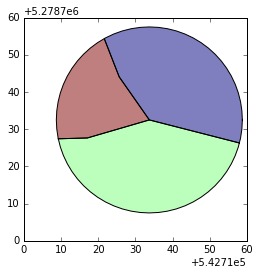

In [24]:
# Example: this intersection region has now been split into nice little sectors!
sectors.iloc[:3].plot()

In [25]:
sectors.to_file('./output/sectors.shp')

In [26]:
# Label every sidewalk endpoint by which sector, if any, it is within
ends.crs = sidewalks.crs
sectors.crs = streets.crs

# For some reason the 'within' spatial join returns 0 rows here, have to
# use slower 'intersects' instead
ends_sectors = gpd.sjoin(ends,
                         sectors,
                         how='inner',
                         op='intersects',
                         lsuffix='end',
                         rsuffix='sec')

ends_sectors.sort_index(inplace=True)

# Copy end count into the endpoints table for filtering later
n_ends = ends_sectors.groupby('index_sec').size()
ends_sectors['n_ends'] = ends_sectors['index_sec'].apply(lambda x: n_ends[x])

ends_sectors.head()

,endtype,geometry,sidewalk_id,index_sec,index_ixn,n_ends
0,start,POINT (553102.8911546955 5286337.80036654),0,50982,17527,2
1,start,POINT (554453.2372857099 5278436.529215374),1,59373,20608,2
2,start,POINT (547070.4454844565 5282921.708989846),2,9465,3450,2
3,start,POINT (550976.5995529721 5264167.420024389),3,36105,12336,2
4,start,POINT (547051.2910976056 5283527.204193444),4,9420,3434,2


In [27]:
# Unfortunately, these ends are not guaranteed to be uniquely assigned to
# a given sector - the sectors overlap when street intersections are closeby.

# Therefore, we need to make a decision: for sidewalk ends assigned to more
# than one sector, which *single* one should be kept? The naive implementation
# is to keep the one that's closet to the intersection itself. However, this
# can result in both sidewalk ends being assigned to the same sector, as the line
# was drawn way too short.

# So, there are two problems we want to solve, in this order:
# A: A given sector may contain *both* sidewalk ends
#    1) Group end-sector table by sidewalk, sector
#    2) If count per group > 1, have identified trouble case
#    3) Drop end farther away from sector's original street intersection
#
# B: A given end may belong in more than one sector. In the future, we may want to
#    address this by modifying the sectors themselves to be non-overlapping, but
#    in the meantime, the strategy will be to drop more-distant rows until unique
#     1) Get the ends belonging to more than one sector (group by sidewalk and endtype)
#     2) For each group, if it has more than one end, drop all but one of end-sector assignments. 
#        Drop the ones that are *farther* from the sector center

In [28]:
# A: A given sector may contain *both* sidewalk ends

#    1) Group end-sector table by sidewalk, sector
ends_sec_count = ends_sectors.groupby(['sidewalk_id', 'index_sec']).size()
print 'Number of sidewalks with both ends in the same sector: ', ends_sec_count[ends_sec_count > 1].shape[0]


#    2) If count per group > 1, have identified trouble case
#    3) Drop end farther away from sector's original street intersection
def uniquify_sw_in_sector(group):
    if group.shape[0] > 1:
        # Get the sidewalk end geometries
        ends = group.geometry

        # Get the intersection geom so we can calc distance
        ixn = intersections.loc[group['index_ixn'].iloc[0]].geometry
        
        
        # Filter to the value to keep - the closest to the intersection
        # TODO: make this step more sophisticated - use other strategy than
        # simple distance to intersection
        end_idx = ends.apply(lambda p: p.distance(ixn)).sort_values().index[0]
        return group[group.index == end_idx]
    else:
        return group

# Create new table with the 'bad' end-sector rows filtered out
ends_sectors_g = ends_sectors.groupby(['sidewalk_id', 'index_sec']).apply(uniquify_sw_in_sector)

# It creates some kind of nasty multi-index. Drop it!
ends_sectors_g.reset_index(drop=True, inplace=True)

ends_sectors_g.head()

Number of sidewalks with both ends in the same sector:  2324


,endtype,geometry,sidewalk_id,index_sec,index_ixn,n_ends
0,start,POINT (553102.8911546955 5286337.80036654),0,50982,17527,2
1,end,POINT (553162.5495850043 5286337.976285667),0,51493,17716,2
2,start,POINT (554453.2372857099 5278436.529215374),1,59373,20608,2
3,end,POINT (554490.0374533416 5278436.835191205),1,59586,20686,2
4,end,POINT (547065.3510885653 5283313.927207816),2,9432,3438,2


In [29]:
# Verify success of step A
print 'Number of sidewalks with both ends in the same sector: ', sum(ends_sectors_g.groupby(['sidewalk_id', 'index_sec']).size() > 1)

Number of sidewalks with both ends in the same sector:  0


In [30]:
# B: A given end may belong in more than one sector. In the future, we may want to
#    address this by modifying the sectors themselves to be non-overlapping, but
#    in the meantime, the strategy will be to drop more-distant rows until unique
#     1) Get the ends belonging to more than one sector - group by sidewalk and endtype
ends_sectors_ends = ends_sectors_g.groupby(['endtype', 'sidewalk_id'])
print 'Number of sidewalk ends belonging to more than one sector: ', sum(ends_sectors_ends.size() > 1)

#     2) For each group, if it has more than one end, drop all but one of end-sector assignments. 
#        Drop the ones that are *farther* from the sector center
def uniquify_end_in_sectors(group):
    if group.shape[0] > 1:
        # Get the sidewalk end geometry
        end = group.geometry.iloc[0]

        # Get the intersection geoms so we can calc distance        
        ixns = group['index_ixn'].apply(lambda ix: intersections.loc[ix].geometry)
        # Filter to the row to keep - the intersection closest to the end
        # TODO: make this step more sophisticated - use other strategy than
        # simple distance to intersection
        sec_idx = ixns.apply(lambda p: p.distance(end)).sort_values().index[0]
        return group[group.index == sec_idx]
    else:
        return group

# Create new table with the 'bad' end-sector rows filtered out
ends_sectors_g2 = ends_sectors_g.groupby(['endtype', 'sidewalk_id']).apply(uniquify_end_in_sectors)

# It creates some kind of nasty multi-index. Drop it!
ends_sectors_g2.reset_index(drop=True, inplace=True)

ends_sectors_g2.head()

Number of sidewalk ends belonging to more than one sector:  3490


,endtype,geometry,sidewalk_id,index_sec,index_ixn,n_ends
0,end,POINT (553162.5495850043 5286337.976285667),0,51493,17716,2
1,end,POINT (554490.0374533416 5278436.835191205),1,59586,20686,2
2,end,POINT (547065.3510885653 5283313.927207816),2,9432,3438,2
3,end,POINT (550976.3976662559 5264091.456287516),3,36100,12334,2
4,end,POINT (547049.9481864078 5283717.536703642),4,9415,3432,2


In [31]:
print 'Number of sidewalk ends belonging to more than one sector: ', sum(ends_sectors_g2.groupby(['endtype', 'sidewalk_id']).size() > 1)

Number of sidewalk ends belonging to more than one sector:  0


In [32]:
# Recalculate n_ends
n_ends = ends_sectors_g2.groupby('index_sec').size()
ends_sectors_g2['n_ends'] = ends_sectors_g2['index_sec'].apply(lambda x: n_ends[x])

In [33]:
ends_sectors_easy = ends_sectors_g2[ends_sectors_g2['n_ends'] == 2]
print 'Easy-fix fraction: ', ends_sectors_easy.shape[0] / float(ends_sectors_g2.shape[0])
ends_sectors_easy.to_file('./output/ends_sectors_easy.shp')

Easy-fix fraction:  0.928903016854


In [34]:
# The easy-fix (2 sidewalk ends to a sector!) ends have been identified.
# Now we need to *move them*. The naive approach is to average their
# geometries. This will create significant offset error, but is super
# easy to do and gives us a good way to visualize the 'fixed vs. non-fixed'
# cases

# TODO: optimize the ends_join function. It's veeeeery slow

def ends_avg(group):
    # Note: expectation is that this is a group of shape (2, n)
    # Find midpoint 'point' between the two
    p1, p2 = group.geometry
    point = geometry.Point([(p1.x + p2.x) / 2, (p1.y + p2.y) / 2])
    
    return gpd.GeoDataFrame({
        'sidewalk_id': group['sidewalk_id'],
        'endtype': group['endtype'],
        'index_sec': group['index_sec'],
        'geometry': [point] * 2
    })

def ends_join(group):
    # Strategy: use midpoint if lines are parallel, use intersection
    #           point if they're orthogonal, and linearly scale between
    
    # Note: expectation is that this is a group of shape (2, n)
    def azimuth(p1, p2):
        radians = np.arctan2(p2[0] - p1[0], p2[1] - p1[1])
        if radians < 0:
            radians += np.pi
        return radians
    
    # Need to look up sidewalks in order to calculate azimuth / intersection points
    segments = []
    azimuths = []

    for i in range(2):
        s = sidewalks.loc[group.iloc[i]['sidewalk_id']]
        s_type = group.iloc[i]['endtype']
        if s_type == 'start':
            # Get the first 2 points
            segment = geometry.LineString(reversed(s.geometry.coords[:2]))
        else:
            # Get the last 2 points
            segment = geometry.LineString(s.geometry.coords[-2:])
        segments.append(segment)
        azimuths.append(azimuth(segment.coords[0], segment.coords[1]))

    # Find the difference in azimuth + the intersection
    dazimuth = abs(azimuths[1] - azimuths[0])
    
    # The 'sin' function is close to what we want - ~0 when
    # dazimuth is ~0 or ~pi (parallel) and ~1 when ~orthogonal
    scale = np.sin(dazimuth)
    
    def intersection(segment1, segment2):
        # Given two line segments, find the intersection
        # point between their representative lines
        def line(segment):
            # Given a line segment, find the line (mx + b)
            # parameters m and b
            xs, ys = segment.xy
            m = (ys[1] - ys[0]) / (xs[1] - xs[0])
            b = ys[0] - (m * xs[0])
            return (m, b)

        m1, b1 = line(segment1)
        m2, b2 = line(segment2)

        x = (b2 - b1) / float((m1 - m2))
        y = m1 * x + b1

        return geometry.Point(x, y)
    
    if scale < 0.1:
        # They're parallelish, use midpoint
        p1, p2 = group.geometry
        point = geometry.Point([(p1.x + p2.x) / 2, (p1.y + p2.y) / 2])
    elif scale > 0.9:
        # They're orthogonalish, use intersection
        point = intersection(*segments)
    else:
        # They're in between - use weighted average
        p1, p2 = group.geometry
        mid = geometry.Point([(p1.x + p2.x) / 2, (p1.y + p2.y) / 2])
        ixn = intersection(*segments)
        
        midx, midy = [scale * coord for coord in mid.coords[0]]
        ixnx, ixny = [(1 - scale) * coord for coord in ixn.coords[0]]
        
        
        point = geometry.Point([midx + ixnx, midy + ixny])

    return gpd.GeoDataFrame({
        'sidewalk_id': group['sidewalk_id'],
        'endtype': group['endtype'],
        'index_sec': group['index_sec'],
        'geometry': [point] * 2
    })


new_ends = ends_sectors_easy.groupby('index_sec').apply(ends_join)
new_ends.crs = ends.crs
new_ends.head()

,endtype,geometry,index_sec,sidewalk_id
0,end,POINT (553162.5495850043 5286337.976285667),51493,0
1,end,POINT (554494.1282786694 5278436.869212953),59586,1
2,end,POINT (547065.3545770072 5283313.159699246),9432,2
3,end,POINT (550976.389382826 5264088.339488655),36100,3
4,end,POINT (547049.9481864078 5283717.536703646),9415,4


0.0144757068904 -172.414294207
[(550991.4315828895, 5278178.050603724)]


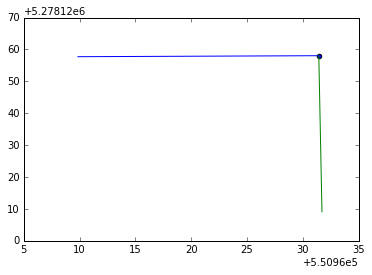

In [35]:
def intersection(segment1, segment2):
    # Given two line segments, find the intersection
    # point between their representative lines
    def line(segment):
        # Given a line segment, find the line (mx + b)
        # parameters m and b
        xs, ys = segment.xy
        m = (ys[1] - ys[0]) / (xs[1] - xs[0])
        b = ys[0] - (m * xs[0])
        return (m, b)
    
    m1, b1 = line(segment1)
    m2, b2 = line(segment2)
    print m1, m2

    x = (b2 - b1) / float((m1 - m2))
    y = m1 * x + b1

    return geometry.Point(x, y)

s1 = sidewalks.loc[2824].geometry
s2 = sidewalks.loc[3549].geometry
# s1 = sidewalks.loc[22736].geometry
# s2 = sidewalks.loc[23780].geometry

s1 = geometry.LineString(s1.coords[-2:])
s2 = geometry.LineString(s2.coords[-2:])
ixn = intersection(s1, s2)

print list(ixn.coords)

plt.plot(*s1.xy)
plt.plot(*s2.xy)
plt.scatter(*ixn.xy);

In [36]:
# Create (sidewalk-indexed) GeoSeries of new sidewalk geometries
def sw_ends_update(sw_row):
    ends_group = new_ends[new_ends['sidewalk_id'] == sw_row['sidewalk_id']]
    if ends_group.empty:
        return sw_row
    else:
        coords = list(sw_row['geometry'].coords)
        start_group = ends_group[ends_group['endtype'] == 'start']
        end_group = ends_group[ends_group['endtype'] == 'end']
        if not start_group.empty:
            coords[0] = start_group['geometry'].iloc[0].coords[0]
        if not end_group.empty:
            coords[-1] = end_group['geometry'].iloc[0].coords[0]
        row_copy = sw_row.copy()
        row_copy['geometry'] = geometry.LineString(coords)
        return row_copy

sector_fixed_sidewalks = sidewalks.apply(sw_ends_update, axis=1)
sector_fixed_sidewalks.crs = sidewalks.crs
sector_fixed_sidewalks.head()

,sidewalk_id,COMPKEY,SEGKEY,curbramp_end,curbramp_start,geometry
0,0,330518,16626,Y,Y,LINESTRING (553102.8911546957 5286337.80036654...
1,1,330507,16724,U,U,LINESTRING (554453.2372857099 5278436.52921537...
2,2,330424,1764,U,U,LINESTRING (547070.6213051372 5282921.68117882...
3,3,330336,8461,U,U,LINESTRING (550976.6073268392 5264170.34509050...
4,4,330419,1766,U,U,LINESTRING (547051.2910976056 5283527.20419344...


In [37]:
# Write ends to file
ends.to_file('./output/ends.shp')
new_ends.to_file('./output/new_ends.shp')
sector_fixed_sidewalks.to_file('./output/sector_fixed_sidewalks.shp')

# Snap nearby ends

As one final step of cleanup, there may be small gaps left over in the dataset in previously-untouched sidewalk endpoints. Naively, we will simply connect endpoints if they're below some threshold (and so long as doing so doesn't result in a line that intersects a street).

In [70]:
# Find sidewalk ends of interest:
#  * Ends that aren't in intersection sectors at all
#  * Ends that were in a sector with n=1
end_nosector = ends[~ends.index.isin(ends_sectors.index)].copy()
end_single = ends[ends.index.isin(ends_sectors[ends_sectors['n_ends'] < 2].index)]

ends_sectors_leftover = pd.concat([end_nosector, end_single])

# list(ends_sectors.index) + 
# ends_sectors_leftover = ends[~ends.index.isin(ends_sectors.index)].copy()
# pd.concat([ends_sectors_leftover, ends_sectors[ends_sectors['n_ends'] < 2]

print ends_sectors_leftover.shape
ends_sectors_leftover.head()

(11539, 3)


,endtype,geometry,sidewalk_id
33,start,POINT (554231.0435601913 5282830.19993804),33
35,start,POINT (553633.4231680527 5282631.546985995),35
41,start,POINT (554414.3717945352 5282724.678282091),41
42,start,POINT (550190.6530848306 5282156.434301921),42
49,start,POINT (550913.2531106473 5280907.729712737),49


In [71]:
# Snap behavior - need to locate other non-modified ends within a certain distance
ends_sectors_leftover.sindex
def nearest_end(row):
    xy = row.geometry.coords[0]
    match2 = ends_sectors_leftover.sindex.nearest(xy, 2, objects=True)
    end_id = list(match2)[1].object
    
    return end_id

ends_sectors_leftover['near_id'] = ends_sectors_leftover.apply(nearest_end, axis=1)
ends_sectors_leftover['near_geom'] = list(ends_sectors_leftover.loc[ends_sectors_leftover['near_id']].geometry)
ends_sectors_leftover['near_dist'] = ends_sectors_leftover.apply(lambda row: row.geometry.distance(row['near_geom']), axis=1)
ends_sectors_leftover.head()

,endtype,geometry,sidewalk_id,near_id,near_geom,near_dist
33,start,POINT (554231.0435601913 5282830.19993804),33,10946,POINT (554249.8334392686 5282840.93035549),21.637962
35,start,POINT (553633.4231680527 5282631.546985995),35,7959,POINT (553620.9306147071 5282631.50416077),12.492627
41,start,POINT (554414.3717945352 5282724.678282091),41,8876,POINT (554403.3690594152 5282718.761665178),12.492659
42,start,POINT (550190.6530848306 5282156.434301921),42,135,POINT (550203.1441022737 5282156.632836232),12.492595
49,start,POINT (550913.2531106473 5280907.729712737),49,61696,POINT (550900.7251863118 5280909.455331372),12.646211


In [72]:
snap_dist = 20
ends_sectors_leftover['near_changed'] = ((ends_sectors_leftover['near_dist'] < snap_dist) & (ends_sectors_leftover['near_dist'] > 0)).astype(int)
ends_sectors_leftover['near_changed'].sum()

9194

In [73]:
# Snap if distance is below threshold
# FIXME: check for snapped lines resulting in street crossing
streets.sindex
def snap(row):
    if row.near_dist < snap_dist and row.near_dist > 0:
        x1, y1 = row.geometry.coords[0]
        x2, y2 = row['near_geom'].coords[0]
        x = (x1 + x2) / 2
        y = (y1 + y2) / 2
        snapped = geometry.Point([x, y])
        
        # Check whether this would create a sidewalk-street intersection
        l1 = geometry.LineString([geometry.Point(x1, y1), snapped])
        l2 = geometry.LineString([geometry.Point(x2, y2), snapped])
        
        for line in [l1, l2]:
            bound_ixn = [x.object for x in streets.sindex.intersection(l1.bounds, objects=True)]
            if bound_ixn:
                if streets.loc[bound_ixn].intersects(line).any():
                    return row.geometry
        return snapped
    else:
        return row.geometry

ends_sectors_leftover['geometry'] = ends_sectors_leftover.apply(snap, axis=1)
ends_sectors_leftover

# Update the dataset
# Create (sidewalk-indexed) GeoSeries of new sidewalk geometries
def sw_ends_update2(sw_row):
    ends_group = ends_sectors_leftover[ends_sectors_leftover['sidewalk_id'] == sw_row['sidewalk_id']]
    if ends_group.empty:
        return sw_row
    else:
        coords = list(sw_row['geometry'].coords)
        start_group = ends_group[ends_group['endtype'] == 'start']
        end_group = ends_group[ends_group['endtype'] == 'end']
        if not start_group.empty:
            coords[0] = start_group['geometry'].iloc[0].coords[0]
        if not end_group.empty:
            coords[-1] = end_group['geometry'].iloc[0].coords[0]
        row_copy = sw_row.copy()
        row_copy['geometry'] = geometry.LineString(coords)
        return row_copy

snap_fixed_sidewalks = sector_fixed_sidewalks.apply(sw_ends_update2, axis=1)
snap_fixed_sidewalks.crs = sidewalks.crs
snap_fixed_sidewalks.head()

,sidewalk_id,COMPKEY,SEGKEY,curbramp_end,curbramp_start,geometry
0,0,330518,16626,Y,Y,LINESTRING (553102.8911546957 5286337.80036654...
1,1,330507,16724,U,U,LINESTRING (554453.2372857099 5278436.52921537...
2,2,330424,1764,U,U,LINESTRING (547070.6213051372 5282921.68117882...
3,3,330336,8461,U,U,LINESTRING (550976.6073268392 5264170.34509050...
4,4,330419,1766,U,U,LINESTRING (547051.2910976056 5283527.20419344...


In [74]:
# Write snapped ends to file
ends_sectors_leftover['endid'] = ends_sectors_leftover.index
ends_sectors_leftover[['endid', 'geometry']].to_file('./output/ends_sectors_leftover.shp')
ends_sectors_leftover[ends_sectors_leftover['near_changed'] == 1][['geometry', 'near_changed']].to_file('./output/snap_fixed_ends.shp')
snap_fixed_sidewalks.to_file('./output/snap_fixed_sidewalks.shp')

In [75]:
ends_sectors_leftover.loc[47297]

endtype                                                 end
geometry        POINT (552199.2036105233 5277529.514903119)
sidewalk_id                                            1769
near_id                                                4580
near_geom       POINT (552213.2631634471 5277540.345858882)
near_dist                                           17.7477
near_changed                                              1
endid                                                 47297
Name: 47297, dtype: object

# Create 'blocks' polygons

In [44]:
# hull = geometry.MultiLineString(list(streets.geometry)).convex_hull.exterior.coords
# hull_lines = [geometry.LineString([hull[i], hull[i + 1]]) for i in range(len(hull) - 1)]
# streets_and_hull = list(streets.geometry) + hull_lines

# blocks = gpd.GeoDataFrame(geometry=list(ops.polygonize(streets_and_hull)))

In [45]:
# blocks.crs = streets0.crs
# blocks = blocks.to_crs({'init': 'epsg:4326'})
# blocks.to_file('./output/blocks.shp')

In [46]:
# polys, dangles, cuts, invalid = [gpd.GeoDataFrame(geometry=list(result)) for result in ops.polygonize_full(streets_and_hull)]

In [47]:
# dangles.crs = streets0.crs
# cuts.crs = streets0.crs
# invalid.crs = streets0.crs

# dangles.to_crs({'init': 'epsg:4326'})
# cuts.to_crs({'init': 'epsg:4326'})
# invalid.to_crs({'init': 'epsg:4326'})

# dangles.to_file('./output/dangles.shp')
# cuts.to_file('./output/cuts.shp')
# invalid.to_file('./output/invalid.shp')